# Proobablistic Matrix Factorization

In [19]:
import numpy as np
import pandas as pd

In [59]:
ratings = pd.read_csv('netflix_data.csv')
ratings.head()

,user_id,movie_id,rating
0,2442,1,3.0
1,1719610,1,2.0
2,1011918,1,4.0
3,479924,1,5.0
4,2389367,1,1.0


In [60]:
ratings.shape

(507852, 3)

In [61]:
user_dict = dict(zip(ratings.user_id.unique(), range(ratings.user_id.nunique())))
movie_dict = dict(zip(ratings.movie_id.unique(), range(ratings.movie_id.nunique())))

In [62]:
ratings_dict = ratings.replace({'user_id':user_dict})
ratings_dict = ratings_dict.replace({'movie_id':movie_dict})

In [63]:
ratings_dict

,user_id,movie_id,rating
0,0,0,3.0
1,1,0,2.0
2,2,0,4.0
3,3,0,5.0
4,4,0,1.0
...,...,...,...
507847,257,4496,5.0
507848,8,4496,1.0
507849,3822,4496,1.0
507850,352,4496,4.0


https://github.com/fuhailin/Probabilistic-Matrix-Factorization/blob/master/RunExample.py

In [64]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings_dict = shuffle(ratings_dict, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings_dict))
ratings_train = ratings_dict.iloc[:cutoff]
ratings_test = ratings_dict.iloc[cutoff:]

In [67]:
class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, lamb_U=0.01, lamb_V = 0.01, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features
        self.epsilon = epsilon  # learning rate
        self.lamb_U = lamb_U
        self.lamb_V = lamb_V
        self.momentum = momentum  # momentum of the gradient
        self.maxepoch = maxepoch  
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization)
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.training_process = []

    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # mean of grading

        pairs_train = train_vec.shape[0]  
        pairs_test = test_vec.shape[0]  

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # Column 0, Total number of users
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # Column 1, Total number of movies

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat) # U 초기치로 정규분포 난수 생성 M x D
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat) # V 초기치로 정규분포 난수 생성 N x D

            self.w_Item_inc = np.zeros((num_item, self.num_feat)) # gradient 담을 공간
            self.w_User_inc = np.zeros((num_user, self.num_feat)) 

        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order) 

            # Batch update
            for batch in range(self.num_batches): 

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0]) 

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]), axis=1) 

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self.lamb_U * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self.lamb_V * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                
                if batch == self.num_batches - 1:
                    
                    # Compute Objective Function after
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 + 0.5 * self.lamb_U * np.linalg.norm(self.w_User) ** 2 \
                        + 0.5 * self.lamb_V * np.linalg.norm(self.w_Item) ** 2
                    rmse1 = np.sqrt(obj / pairs_train)

                    # Compute validation error
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    rmse2 = np.linalg.norm(rawErr) / np.sqrt(pairs_test)
                    
                    self.training_process.append((self.epoch, rmse1, rmse2))

                    if self.epoch % 5 == 0:
                        print('iteration %f : Training RMSE %f, Test RMSE %f' % (self.epoch, rmse1, rmse2))
        return self.training_process, self.w_User, self.w_Item

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            #self._lambda = parameters.get("_lambda", 0.1)
            self.lamb_U = parameters.get("lamb_U", 0.01)
            self.lamb_V = parameters.get("lamb_V", 0.01)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

## lambda_U = 0.01, lambda_V = 0.001

In [101]:
pmf1 = PMF()
pmf1.set_params({"num_feat": 10, "epsilon": 1, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [102]:
import time
start = time.time()

pmf_result1, U_1, V_1 = pmf1.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.092139, Test RMSE 1.097748
iteration 10.000000 : Training RMSE 1.083200, Test RMSE 1.093431
iteration 15.000000 : Training RMSE 1.036673, Test RMSE 1.061763
iteration 20.000000 : Training RMSE 0.966133, Test RMSE 1.016425
iteration 25.000000 : Training RMSE 0.910264, Test RMSE 0.985555
iteration 30.000000 : Training RMSE 0.873517, Test RMSE 0.970445
iteration 35.000000 : Training RMSE 0.847331, Test RMSE 0.963829
iteration 40.000000 : Training RMSE 0.827433, Test RMSE 0.961478
iteration 45.000000 : Training RMSE 0.811755, Test RMSE 0.961048
iteration 50.000000 : Training RMSE 0.799079, Test RMSE 0.961526
93.45875072479248


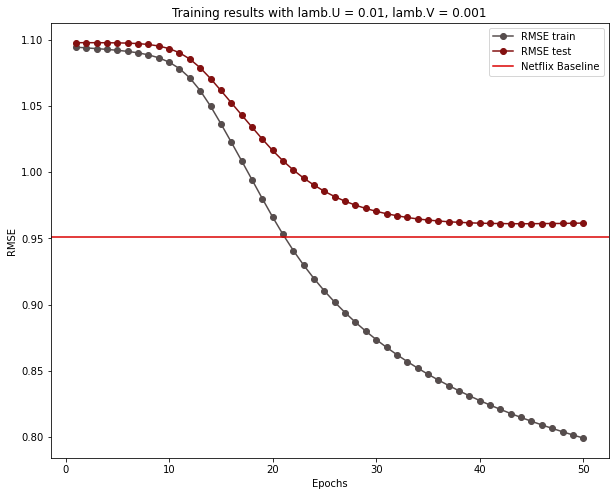

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result1)[:,0]
train_rmse_list = np.array(pmf_result1)[:,1]
test_rmse_list = np.array(pmf_result1)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.001, lambda_V = 0.0001

In [81]:
pmf2 = PMF()
pmf2.set_params({"num_feat": 10, "epsilon": 1, "lamb_U": 0.001, "lamb_V" : 0.0001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [82]:
import time
start = time.time()

pmf_result2, U_2, V_2 = pmf2.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.092469, Test RMSE 1.097938
iteration 10.000000 : Training RMSE 1.086773, Test RMSE 1.096717
iteration 15.000000 : Training RMSE 1.053803, Test RMSE 1.079220
iteration 20.000000 : Training RMSE 0.975602, Test RMSE 1.031999
iteration 25.000000 : Training RMSE 0.920326, Test RMSE 0.999957
iteration 30.000000 : Training RMSE 0.882587, Test RMSE 0.983795
iteration 35.000000 : Training RMSE 0.854072, Test RMSE 0.976082
iteration 40.000000 : Training RMSE 0.832624, Test RMSE 0.972781
iteration 45.000000 : Training RMSE 0.816059, Test RMSE 0.971884
iteration 50.000000 : Training RMSE 0.802856, Test RMSE 0.971628
87.4956464767456


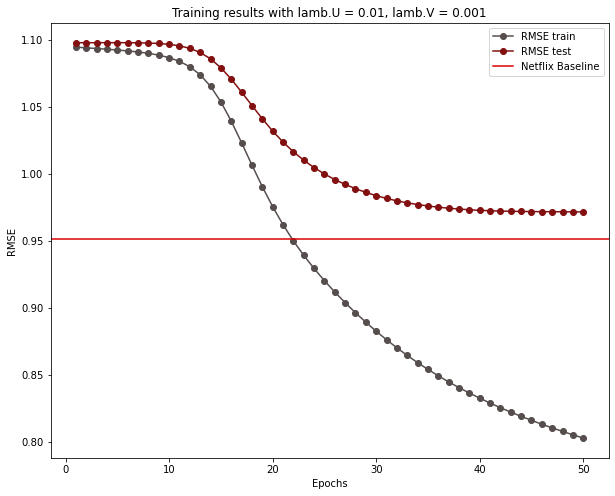

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result2)[:,0]
train_rmse_list = np.array(pmf_result2)[:,1]
test_rmse_list = np.array(pmf_result2)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.001, lambda_V = 0.001

In [84]:
pmf3 = PMF()
pmf3.set_params({"num_feat": 10, "epsilon": 1, "lamb_U": 0.001, "lamb_V" : 0.001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [85]:
import time
start = time.time()

pmf_result3, U_3, V_3 = pmf3.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.092101, Test RMSE 1.097619
iteration 10.000000 : Training RMSE 1.081648, Test RMSE 1.093030
iteration 15.000000 : Training RMSE 1.026036, Test RMSE 1.058925
iteration 20.000000 : Training RMSE 0.954062, Test RMSE 1.012528
iteration 25.000000 : Training RMSE 0.908270, Test RMSE 0.986242
iteration 30.000000 : Training RMSE 0.875367, Test RMSE 0.972549
iteration 35.000000 : Training RMSE 0.849699, Test RMSE 0.965967
iteration 40.000000 : Training RMSE 0.829462, Test RMSE 0.963364
iteration 45.000000 : Training RMSE 0.813321, Test RMSE 0.962620
iteration 50.000000 : Training RMSE 0.800215, Test RMSE 0.962753
87.41289448738098


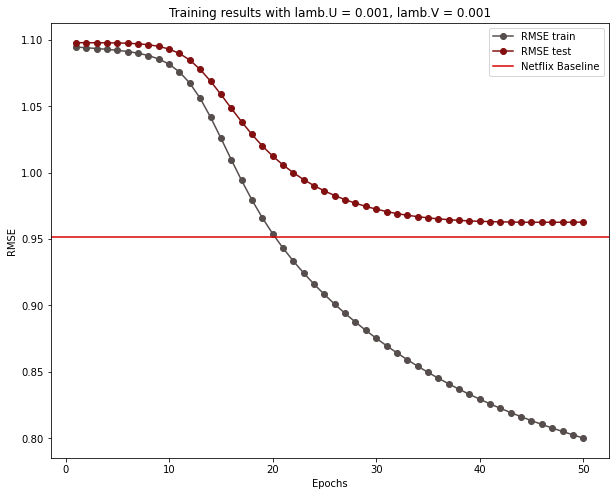

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result3)[:,0]
train_rmse_list = np.array(pmf_result3)[:,1]
test_rmse_list = np.array(pmf_result3)[:,2]

plt.title('Training results with lamb.U = 0.001, lamb.V = 0.001')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.01, lambda_V = 0.001 -- 학습률 0.1

In [218]:
pmf3_2 = PMF()
pmf3_2.set_params({"num_feat": 10, "epsilon": 0.1, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [219]:
import time
start = time.time()

pmf_result3_2, U_3_2, V_3_2 = pmf3_2.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.094744, Test RMSE 1.097850
iteration 10.000000 : Training RMSE 1.094453, Test RMSE 1.097837
iteration 15.000000 : Training RMSE 1.094164, Test RMSE 1.097826
iteration 20.000000 : Training RMSE 1.093873, Test RMSE 1.097814
iteration 25.000000 : Training RMSE 1.093576, Test RMSE 1.097798
iteration 30.000000 : Training RMSE 1.093267, Test RMSE 1.097778
iteration 35.000000 : Training RMSE 1.092938, Test RMSE 1.097749
iteration 40.000000 : Training RMSE 1.092584, Test RMSE 1.097706
iteration 45.000000 : Training RMSE 1.092194, Test RMSE 1.097644
iteration 50.000000 : Training RMSE 1.091755, Test RMSE 1.097558
346.0560326576233


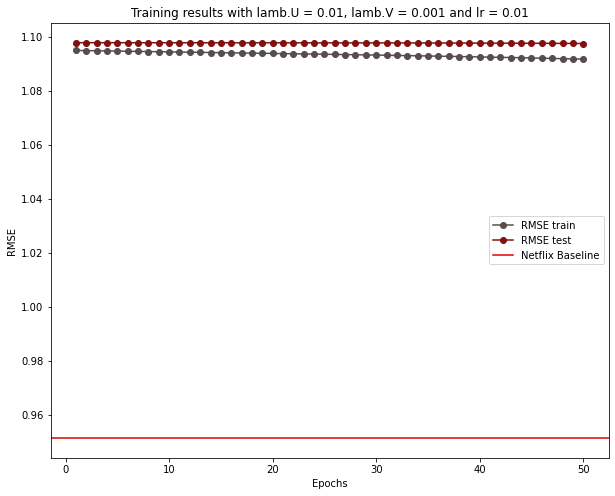

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result3_2)[:,0]
train_rmse_list = np.array(pmf_result3_2)[:,1]
test_rmse_list = np.array(pmf_result3_2)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001 and lr = 0.01')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.01, lambda_V = 0.001 -- 학습률 0.05

In [222]:
pmf3_3 = PMF()
pmf3_3.set_params({"num_feat": 10, "epsilon": 0.05, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [223]:
import time
start = time.time()

pmf_result3_3, U_3_3, V_3_3 = pmf3_3.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.094916, Test RMSE 1.097988
iteration 10.000000 : Training RMSE 1.094761, Test RMSE 1.097982
iteration 15.000000 : Training RMSE 1.094609, Test RMSE 1.097978
iteration 20.000000 : Training RMSE 1.094459, Test RMSE 1.097974
iteration 25.000000 : Training RMSE 1.094311, Test RMSE 1.097971
iteration 30.000000 : Training RMSE 1.094162, Test RMSE 1.097969
iteration 35.000000 : Training RMSE 1.094014, Test RMSE 1.097966
iteration 40.000000 : Training RMSE 1.093865, Test RMSE 1.097964
iteration 45.000000 : Training RMSE 1.093714, Test RMSE 1.097962
iteration 50.000000 : Training RMSE 1.093562, Test RMSE 1.097958
342.7715289592743


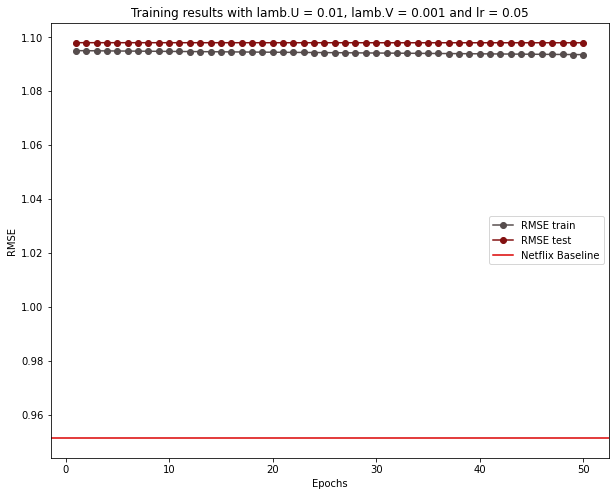

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result3_3)[:,0]
train_rmse_list = np.array(pmf_result3_3)[:,1]
test_rmse_list = np.array(pmf_result3_3)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001 and lr = 0.05')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.01, lambda_V = 0.001 -- 학습률 2

In [225]:
pmf3_4 = PMF()
pmf3_4.set_params({"num_feat": 10, "epsilon": 2, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.9, "maxepoch": 50, "num_batches": 50,
                "batch_size": 10000})

In [226]:
import time
start = time.time()

pmf_result3_4, U_3_4, V_3_4 = pmf3_4.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.083466, Test RMSE 1.093764
iteration 10.000000 : Training RMSE 0.959821, Test RMSE 1.014407
iteration 15.000000 : Training RMSE 0.879455, Test RMSE 0.975586
iteration 20.000000 : Training RMSE 0.833035, Test RMSE 0.966096
iteration 25.000000 : Training RMSE 0.803421, Test RMSE 0.965001
iteration 30.000000 : Training RMSE 0.783386, Test RMSE 0.966616
iteration 35.000000 : Training RMSE 0.768821, Test RMSE 0.968616
iteration 40.000000 : Training RMSE 0.757597, Test RMSE 0.970956
iteration 45.000000 : Training RMSE 0.748618, Test RMSE 0.973160
iteration 50.000000 : Training RMSE 0.741224, Test RMSE 0.975219
414.8878321647644


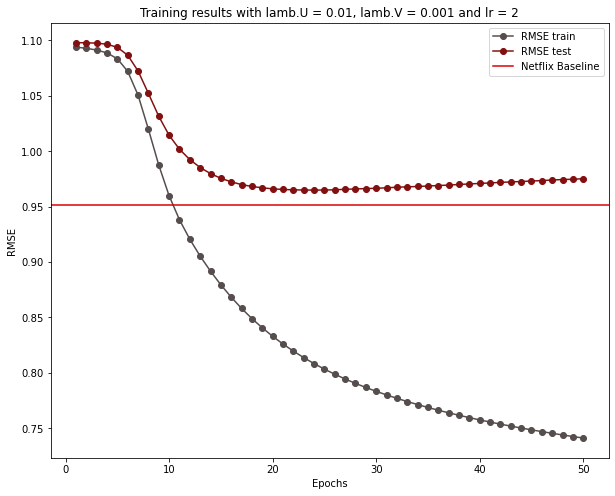

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result3_4)[:,0]
train_rmse_list = np.array(pmf_result3_4)[:,1]
test_rmse_list = np.array(pmf_result3_4)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001 and lr = 2')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.01, lambda_V = 0.001 -- momentum 0.8

In [269]:
pmf4 = PMF()
pmf4.set_params({"num_feat": 10, "epsilon": 1, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.8, "maxepoch": 100, "num_batches": 50,
                "batch_size": 10000})

In [229]:
#### import time
start = time.time()

pmf_result4, U_4, V_4 = pmf4.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.093582, Test RMSE 1.097825
iteration 10.000000 : Training RMSE 1.091947, Test RMSE 1.097682
iteration 15.000000 : Training RMSE 1.089144, Test RMSE 1.096997
iteration 20.000000 : Training RMSE 1.082557, Test RMSE 1.094202
iteration 25.000000 : Training RMSE 1.065710, Test RMSE 1.084927
iteration 30.000000 : Training RMSE 1.031744, Test RMSE 1.063578
iteration 35.000000 : Training RMSE 0.989350, Test RMSE 1.035103
iteration 40.000000 : Training RMSE 0.953531, Test RMSE 1.011821
iteration 45.000000 : Training RMSE 0.926222, Test RMSE 0.995666
iteration 50.000000 : Training RMSE 0.904230, Test RMSE 0.984106
iteration 55.000000 : Training RMSE 0.885840, Test RMSE 0.975752
iteration 60.000000 : Training RMSE 0.870245, Test RMSE 0.969903
iteration 65.000000 : Training RMSE 0.856818, Test RMSE 0.965863
iteration 70.000000 : Training RMSE 0.845176, Test RMSE 0.963349
iteration 75.000000 : Training RMSE 0.834949, Test RMSE 0.961743
iteration 80.000000 : Trai

In [230]:
pd.DataFrame(pmf_result4, columns = ['epoch', 'train_rmse', 'test_rmse']).to_csv('pmf_result.csv', index=False)

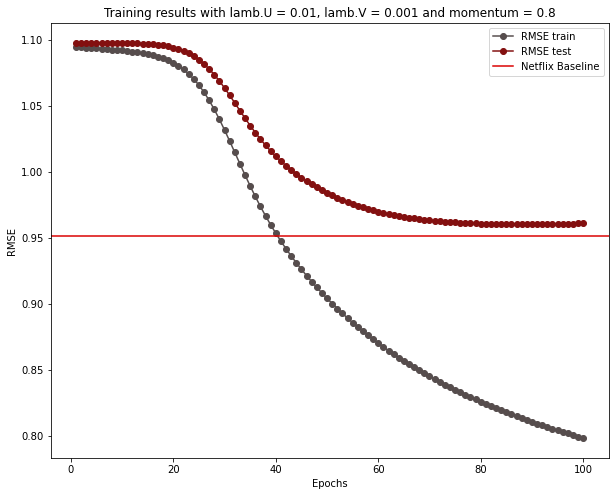

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result4)[:,0]
train_rmse_list = np.array(pmf_result4)[:,1]
test_rmse_list = np.array(pmf_result4)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001 and momentum = 0.8')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## lambda_U = 0.01, lambda_V = 0.001 -- momentum 0.5

In [232]:
pmf4_2 = PMF()
pmf4_2.set_params({"num_feat": 10, "epsilon": 1, "lamb_U": 0.01, "lamb_V" : 0.001, "momentum": 0.5, "maxepoch": 100, "num_batches": 50,
                "batch_size": 10000})

In [233]:
import time
start = time.time()

pmf_result4_2, U_4_2, V_4_2 = pmf4_2.fit(ratings_train.values, ratings_test.values)

print(time.time()-start)

iteration 5.000000 : Training RMSE 1.094399, Test RMSE 1.097937
iteration 10.000000 : Training RMSE 1.093829, Test RMSE 1.097931
iteration 15.000000 : Training RMSE 1.093238, Test RMSE 1.097925
iteration 20.000000 : Training RMSE 1.092597, Test RMSE 1.097907
iteration 25.000000 : Training RMSE 1.091850, Test RMSE 1.097856
iteration 30.000000 : Training RMSE 1.090925, Test RMSE 1.097746
iteration 35.000000 : Training RMSE 1.089718, Test RMSE 1.097526
iteration 40.000000 : Training RMSE 1.088050, Test RMSE 1.097114
iteration 45.000000 : Training RMSE 1.085665, Test RMSE 1.096364
iteration 50.000000 : Training RMSE 1.082167, Test RMSE 1.095052
iteration 55.000000 : Training RMSE 1.077020, Test RMSE 1.092814
iteration 60.000000 : Training RMSE 1.069579, Test RMSE 1.089168
iteration 65.000000 : Training RMSE 1.059232, Test RMSE 1.083570
iteration 70.000000 : Training RMSE 1.045814, Test RMSE 1.075613
iteration 75.000000 : Training RMSE 1.029801, Test RMSE 1.065410
iteration 80.000000 : Trai

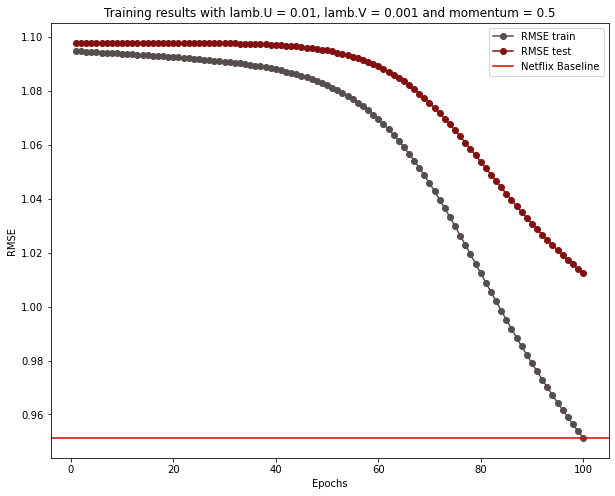

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(pmf_result4_2)[:,0]
train_rmse_list = np.array(pmf_result4_2)[:,1]
test_rmse_list = np.array(pmf_result4_2)[:,2]

plt.title('Training results with lamb.U = 0.01, lamb.V = 0.001 and momentum = 0.5')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

## 최종 모델 결과 확인

In [256]:
df_movies = pd.read_csv('netflix_data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['movie_id', 'year', 'title'])
df_movies = df_movies.replace({'user_id':user_dict})
df_movies = df_movies.replace({'movie_id':movie_dict})

In [257]:
user_id = user_dict.get(2442)
print(user_id)

0


In [258]:
R_2442 = pd.DataFrame(pmf4.predict(user_id)).reset_index()
R_2442.columns = ['movie_id','rating_pred']

In [259]:
R_2442.head()

,movie_id,rating_pred
0,0,3.565371
1,1,3.641833
2,2,3.778583
3,3,3.624064
4,4,3.646987


In [260]:
df_movies.head()

,movie_id,year,title
0,0,2003.0,Dinosaur Planet
1,1,2004.0,Isle of Man TT 2004 Review
2,2,1997.0,Character
3,3,1994.0,Paula Abdul's Get Up & Dance
4,4,2004.0,The Rise and Fall of ECW


In [261]:
ratings_dict.movie_id.unique()

array([4303, 3667, 4352, ..., 1810,  548, 3745], dtype=int64)

In [262]:
R_result = pd.merge(pd.merge(df_movies, R_2442, how='inner', on='movie_id'), 
                    ratings_dict[ratings_dict['user_id']==user_id].drop('user_id',axis=1), how='left', on='movie_id')

In [263]:
R_fitted = R_result[R_result['rating'].isna()==False]
R_fitted = R_fitted[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

In [265]:
R_fitted.head(10)

,movie_id,title,rating,rating_pred
0,0,Dinosaur Planet,3.0,3.565371
1,29,Something's Gotta Give,3.0,3.823515
2,187,Dead Birds,3.0,3.408520
3,190,X2: X-Men United,4.0,4.054227
4,282,If These Walls Could Talk,4.0,3.710069
5,456,Kill Bill: Vol. 2,3.0,3.366525
6,485,Journey to the Center of the Earth,4.0,3.456025
7,513,Santana: Supernatural Live,3.0,3.543549
8,527,The Hitchhiker's Guide to the Galaxy,4.0,2.736385
9,593,By Hook or By Crook,2.0,3.527677


In [266]:
# 원래 취향
R_fitted.sort_values(by=['rating'], ascending=False).head(10)

,movie_id,title,rating,rating_pred
18,1082,Walking with Prehistoric Beasts,5.0,3.832549
73,2860,The Silence of the Lambs,5.0,4.207895
23,1389,Yanni: Live at the Acropolis,5.0,3.579948
78,3110,Dante's Peak,5.0,3.291114
79,3181,Desert Hearts,5.0,3.580797
26,1468,Bend It Like Beckham,5.0,3.705519
27,1480,Beyond Borders,5.0,3.492514
92,3668,Laughing Matters,5.0,3.733208
57,2450,Lord of the Rings: The Fellowship of the Ring,5.0,4.484694
31,1707,Clash of the Titans,5.0,3.726379


In [267]:
R_pred = R_result[R_result['rating'].isna()==True]
R_pred = R_pred[['movie_id','title','rating','rating_pred']].reset_index(drop=True)

In [268]:
# 추천
R_pred.sort_values(by=['rating_pred'], ascending=False).head(10)

,movie_id,title,rating,rating_pred
2115,2160,CSI: Season 1,NaN,4.631397
4193,4303,The Sixth Sense,NaN,4.477036
2708,2780,Braveheart,NaN,4.430554
2486,2546,Gilmore Girls: Season 1,NaN,4.411368
1448,1474,Six Feet Under: Season 4,NaN,4.360109
265,269,Sex and the City: Season 4,NaN,4.336044
3027,3103,Ghost,NaN,4.332624
2068,2112,Firefly,NaN,4.318385
1765,1796,Lethal Weapon,NaN,4.307304
3000,3077,The Lion King: Special Edition,NaN,4.303823
